In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import DataFrame
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.manifold import TSNE

In [2]:
import seaborn as sns

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [3]:
df = pd.read_csv('dataset/dataset.csv')

In [4]:
label_ = list(set(df['label_action']))
label_cnt = len(label_)

idx = []
for i in range (0, label_cnt):
    idx.append(i)
ldf = df.replace(label_, idx)

# 0. Preprocessing

## 0.1. Decode URL
URL은 %NN 형태로 인코딩되어있기 때문에 디코딩을 해줄 것이다.

In [5]:
from urllib.parse import unquote
#test
test_url = ldf.payload[4]
dec_url = unquote(test_url)
print("Before:", test_url)
print("After:", dec_url)



Before: GET /sub_04_1_read.php?page=1&id=31%29%3BSELECT%20%2A%20FROM%20GENERATE_SERIES%289156%2C9156%2CCASE%20WHEN%20%289156%3D5350%29%20THEN%201%20ELSE%200%20END%29%20LIMIT%201-- HTTP/1.1\r\nCache-Control: no-cache\r\nUser-Agent: sqlmap/1.6.10#stable (https://sqlmap.org)\r\nReferer: http://10.0.17.20:80/sub_04_1_read.php\r\nHost: 10.0.17.20\r\nAccept: */*\r\nAccept-Encoding: gzip,deflate\r\nConnection: close\r\n\r\n
After: GET /sub_04_1_read.php?page=1&id=31);SELECT * FROM GENERATE_SERIES(9156,9156,CASE WHEN (9156=5350) THEN 1 ELSE 0 END) LIMIT 1-- HTTP/1.1\r\nCache-Control: no-cache\r\nUser-Agent: sqlmap/1.6.10#stable (https://sqlmap.org)\r\nReferer: http://10.0.17.20:80/sub_04_1_read.php\r\nHost: 10.0.17.20\r\nAccept: */*\r\nAccept-Encoding: gzip,deflate\r\nConnection: close\r\n\r\n


이런 형태로 모든 스트링에 적용시켜준다

In [6]:
from urllib.parse import unquote
decoded_payload = []
for url in ldf.payload:
    decoded_payload.append(unquote(url))
pd.options.display.max_colwidth = 100
ldf.payload = decoded_payload


In [7]:
ldf.to_csv("./decoded.csv", escapechar='\\')

잘 디코딩이 된 것을 확인할 수 있다.

## 0.2. 불필요한 데이터 제거
payload의 모든 내용이 학습에 도움이 되는 것은 아니다. 
문자열을 feature data로 사용할 때 중요한 것은 실제로 공격에 사용된 부분이다. 
따라서 크게 영향을 주지 않을 것으로 부분들을 제거할것이다

In [8]:
duplicate_values = ldf['payload'].duplicated()
i = 0
cnt = 0
for pl in df.payload:
    if (duplicate_values[i] == True):
        cnt += 1
    i += 1
print("Number of dupes: ", cnt)

Number of dupes:  13246


In [9]:
ldf = ldf.drop_duplicates(subset=['payload'])

In [10]:
ldf

,Log_Number,payload,label_action
0,0,"GET /forum1_professionnel.asp?n=/.\\\""./.\\\""./.\\\""./.\\\""./.\\\""./boot.ini&amp;nn=100&amp;page...",1
1,1,"POST /owa/auth/logon.aspx?replaceCurrent=1"") AND 9294=UTL_INADDR.GET_HOST_ADDRESS(CHR(113)||CHR(...",1
2,2,GET /goods/goods_search?display_type=list&arr_search_list[0][search_type]=-1839 or 1=2&arr_searc...,3
3,3,GET / HTTP/1.1\r\n\r\n,7
4,4,"GET /sub_04_1_read.php?page=1&id=31);SELECT * FROM GENERATE_SERIES(9156,9156,CASE WHEN (9156=535...",1
...,...,...,...
44993,44993,GET /admin/captcha/securimage_show?160c3e6d29ea99621a9ddced77261577=../../../../../../../../../....,6
44995,44995,GET /app/javascript/js/skin-responsive.js?v=; HTTP/1.1\r\nHost: www.mall.shop\r\nUser-Agent: Moz...,1
44996,44996,GET /board/?category=type+%SYSTEMROOT%\win.ini&goods_seq=&id=goods_qna&iframe=&page=&perpage=&po...,1
44997,44997,POST /sub_02_4.php HTTP/1.1\r\nContent-Length: 118\r\nCache-Control: no-cache\r\nCookie: df8k365...,3


### Lower Case

In [11]:
low_payloads = []

for payloads in ldf.payload:
    low_payloads.append(payloads.lower())

ldf.payload = low_payloads
ldf

,Log_Number,payload,label_action
0,0,"get /forum1_professionnel.asp?n=/.\\\""./.\\\""./.\\\""./.\\\""./.\\\""./boot.ini&amp;nn=100&amp;page...",1
1,1,"post /owa/auth/logon.aspx?replacecurrent=1"") and 9294=utl_inaddr.get_host_address(chr(113)||chr(...",1
2,2,get /goods/goods_search?display_type=list&arr_search_list[0][search_type]=-1839 or 1=2&arr_searc...,3
3,3,get / http/1.1\r\n\r\n,7
4,4,"get /sub_04_1_read.php?page=1&id=31);select * from generate_series(9156,9156,case when (9156=535...",1
...,...,...,...
44993,44993,get /admin/captcha/securimage_show?160c3e6d29ea99621a9ddced77261577=../../../../../../../../../....,6
44995,44995,get /app/javascript/js/skin-responsive.js?v=; http/1.1\r\nhost: www.mall.shop\r\nuser-agent: moz...,1
44996,44996,get /board/?category=type+%systemroot%\win.ini&goods_seq=&id=goods_qna&iframe=&page=&perpage=&po...,1
44997,44997,post /sub_02_4.php http/1.1\r\ncontent-length: 118\r\ncache-control: no-cache\r\ncookie: df8k365...,3


## Tokenizing
공백, &, =, :, ;, +로 문자열 분리하기

In [12]:

split_payload = []
for payload in ldf.payload:
    payload = payload.replace("\\r\\n",',')
    table = payload.maketrans("&=;: ()", ",,,,,,,")
    payload = payload.translate(table)
    tokens = payload.split(',')
    #tokens = payload.split('\\r\\n')
    while("" in tokens):
        tokens.remove('')
    split_payload.append(tokens)
ldf.payload = split_payload

In [13]:
ldf.to_csv("./split.csv")

In [14]:
ldf

,Log_Number,payload,label_action
0,0,"[get, /forum1_professionnel.asp?n, /.\\\""./.\\\""./.\\\""./.\\\""./.\\\""./boot.ini, amp, nn, 100, a...",1
1,1,"[post, /owa/auth/logon.aspx?replacecurrent, 1"", and, 9294, utl_inaddr.get_host_address, chr, 113...",1
2,2,"[get, /goods/goods_search?display_type, list, arr_search_list[0][search_type], -1839, or, 1, 2, ...",3
3,3,"[get, /, http/1.1]",7
4,4,"[get, /sub_04_1_read.php?page, 1, id, 31, select, *, from, generate_series, 9156, 9156, case, wh...",1
...,...,...,...
44993,44993,"[get, /admin/captcha/securimage_show?160c3e6d29ea99621a9ddced77261577, ../../../../../../../../....",6
44995,44995,"[get, /app/javascript/js/skin-responsive.js?v, http/1.1, host, www.mall.shop, user-agent, mozill...",1
44996,44996,"[get, /board/?category, type+%systemroot%\win.ini, goods_seq, id, goods_qna, iframe, page, perpa...",1
44997,44997,"[post, /sub_02_4.php, http/1.1, content-length, 118, cache-control, no-cache, cookie, df8k36559u...",3


#Hash

In [15]:
# from hashlib import sha256

# # for payload in ldf.payload:
# #     if (len(payload) == 185):
# #         print(payload)
# new_payload = []
# for payload in ldf.payload:
#     hashed_payload = []
#     for field in payload:
#         hash = sha256(field.encode())
#         hash2 = hash.hexdigest()
#         hashed_payload.append(hash2)
#     new_payload.append(hashed_payload)
# ldf.payload = new_payload



In [16]:
ldf

,Log_Number,payload,label_action
0,0,"[get, /forum1_professionnel.asp?n, /.\\\""./.\\\""./.\\\""./.\\\""./.\\\""./boot.ini, amp, nn, 100, a...",1
1,1,"[post, /owa/auth/logon.aspx?replacecurrent, 1"", and, 9294, utl_inaddr.get_host_address, chr, 113...",1
2,2,"[get, /goods/goods_search?display_type, list, arr_search_list[0][search_type], -1839, or, 1, 2, ...",3
3,3,"[get, /, http/1.1]",7
4,4,"[get, /sub_04_1_read.php?page, 1, id, 31, select, *, from, generate_series, 9156, 9156, case, wh...",1
...,...,...,...
44993,44993,"[get, /admin/captcha/securimage_show?160c3e6d29ea99621a9ddced77261577, ../../../../../../../../....",6
44995,44995,"[get, /app/javascript/js/skin-responsive.js?v, http/1.1, host, www.mall.shop, user-agent, mozill...",1
44996,44996,"[get, /board/?category, type+%systemroot%\win.ini, goods_seq, id, goods_qna, iframe, page, perpa...",1
44997,44997,"[post, /sub_02_4.php, http/1.1, content-length, 118, cache-control, no-cache, cookie, df8k36559u...",3


In [17]:
max_len = 0
field_len = []
for payload in ldf.payload:
    max_len = max(max_len, len(payload))
i = 0
print("Max len: ", max_len)
for payload in ldf.payload:
    field_len.append(len(payload))

print(field_len)

Max len:  940
[28, 71, 59, 3, 42, 28, 112, 34, 29, 25, 14, 57, 21, 50, 101, 33, 77, 119, 81, 78, 81, 37, 58, 111, 60, 21, 16, 25, 97, 38, 39, 68, 56, 25, 20, 150, 20, 25, 48, 21, 23, 8, 15, 21, 77, 27, 37, 110, 21, 76, 41, 69, 131, 21, 64, 49, 8, 22, 33, 55, 56, 37, 27, 97, 76, 79, 62, 24, 96, 48, 73, 115, 21, 54, 16, 80, 16, 55, 139, 32, 97, 28, 19, 21, 69, 81, 22, 9, 21, 57, 25, 105, 57, 97, 27, 123, 25, 63, 21, 15, 92, 49, 39, 40, 41, 25, 69, 26, 92, 101, 112, 26, 77, 15, 127, 57, 20, 19, 17, 23, 55, 17, 21, 44, 21, 19, 60, 23, 26, 40, 52, 64, 25, 78, 85, 22, 9, 3, 40, 15, 28, 20, 54, 34, 19, 57, 80, 64, 21, 57, 27, 118, 14, 27, 34, 71, 45, 77, 52, 113, 19, 92, 110, 92, 116, 27, 74, 50, 28, 15, 119, 43, 124, 104, 40, 85, 49, 68, 20, 19, 29, 93, 19, 29, 20, 28, 23, 77, 96, 37, 22, 19, 57, 38, 15, 77, 43, 23, 39, 19, 19, 20, 39, 22, 8, 110, 15, 87, 42, 30, 57, 21, 61, 30, 19, 19, 14, 111, 17, 91, 75, 19, 15, 24, 21, 42, 29, 85, 19, 38, 37, 66, 70, 97, 39, 19, 17, 112, 77, 129, 19, 15,

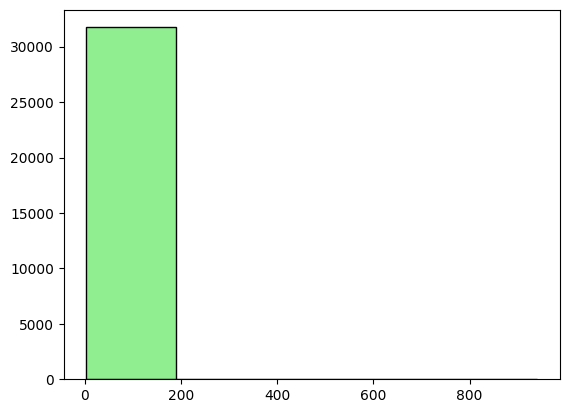

53.467248220696604

In [18]:
import matplotlib.pyplot as plt

#create histogram
plt.hist(field_len, color='lightgreen', ec='black', bins=5)
plt.show()
np.average(field_len)

In [19]:
ldf['token_num'] = field_len 

In [20]:
ldf = ldf[ldf.token_num < 149]

In [21]:
ldf

,Log_Number,payload,label_action,token_num
0,0,"[get, /forum1_professionnel.asp?n, /.\\\""./.\\\""./.\\\""./.\\\""./.\\\""./boot.ini, amp, nn, 100, a...",1,28
1,1,"[post, /owa/auth/logon.aspx?replacecurrent, 1"", and, 9294, utl_inaddr.get_host_address, chr, 113...",1,71
2,2,"[get, /goods/goods_search?display_type, list, arr_search_list[0][search_type], -1839, or, 1, 2, ...",3,59
3,3,"[get, /, http/1.1]",7,3
4,4,"[get, /sub_04_1_read.php?page, 1, id, 31, select, *, from, generate_series, 9156, 9156, case, wh...",1,42
...,...,...,...,...
44993,44993,"[get, /admin/captcha/securimage_show?160c3e6d29ea99621a9ddced77261577, ../../../../../../../../....",6,109
44995,44995,"[get, /app/javascript/js/skin-responsive.js?v, http/1.1, host, www.mall.shop, user-agent, mozill...",1,65
44996,44996,"[get, /board/?category, type+%systemroot%\win.ini, goods_seq, id, goods_qna, iframe, page, perpa...",1,100
44997,44997,"[post, /sub_02_4.php, http/1.1, content-length, 118, cache-control, no-cache, cookie, df8k36559u...",3,41


(array([12897.,  6767.,  6091.,  4296.,  1595.]),
 array([  3.,  32.,  61.,  90., 119., 148.]),
 <BarContainer object of 5 artists>)

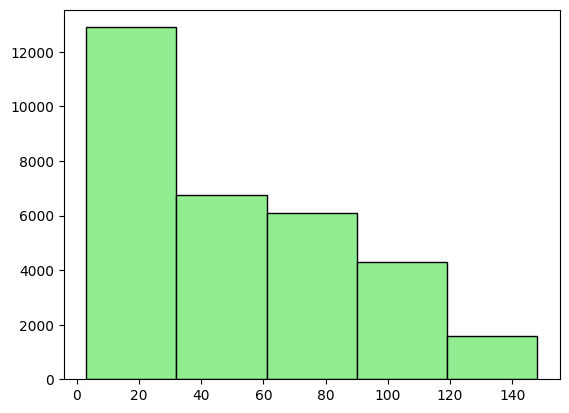

In [22]:
#create histogram
plt.hist(ldf.token_num, color='lightgreen', ec='black', bins=5)

In [23]:
max_len = 0
for token_num in ldf.token_num:
    max_len = max(max_len, token_num)
print(max_len)

148


In [24]:
for payload in ldf.payload:
    while (len(payload) < 149):
        payload.append("")


/var/folders/23/4bd4g9557nx3y86thm_2yqxm0000gn/T/ipykernel_32788/1545888522.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ldf['token_num'] = field_len


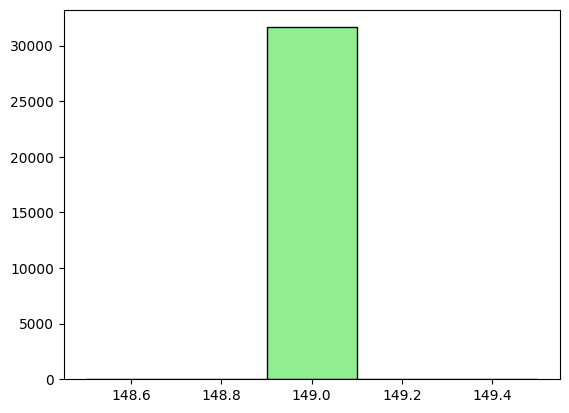

[149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149,

In [25]:
#create histogram
field_len = []
for payload in ldf.payload:
    field_len.append(len(payload))
ldf['token_num'] = field_len 


plt.hist(ldf.token_num, color='lightgreen', ec='black', bins=5)
plt.show()
print(field_len)

In [26]:
# from hashlib import sha256
# new_payload = []
# for payload in ldf.payload:
#     hashed_payload = []
#     for token in payload:
#         hash = sha256(token.encode())
#         hash2 = hash.hexdigest()
#         hashed_payload.append(hash2)
#     new_payload.append(hashed_payload)
# ldf.payload = new_payload

In [27]:
ldf

,Log_Number,payload,label_action,token_num
0,0,"[get, /forum1_professionnel.asp?n, /.\\\""./.\\\""./.\\\""./.\\\""./.\\\""./boot.ini, amp, nn, 100, a...",1,149
1,1,"[post, /owa/auth/logon.aspx?replacecurrent, 1"", and, 9294, utl_inaddr.get_host_address, chr, 113...",1,149
2,2,"[get, /goods/goods_search?display_type, list, arr_search_list[0][search_type], -1839, or, 1, 2, ...",3,149
3,3,"[get, /, http/1.1, , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , ,...",7,149
4,4,"[get, /sub_04_1_read.php?page, 1, id, 31, select, *, from, generate_series, 9156, 9156, case, wh...",1,149
...,...,...,...,...
44993,44993,"[get, /admin/captcha/securimage_show?160c3e6d29ea99621a9ddced77261577, ../../../../../../../../....",6,149
44995,44995,"[get, /app/javascript/js/skin-responsive.js?v, http/1.1, host, www.mall.shop, user-agent, mozill...",1,149
44996,44996,"[get, /board/?category, type+%systemroot%\win.ini, goods_seq, id, goods_qna, iframe, page, perpa...",1,149
44997,44997,"[post, /sub_02_4.php, http/1.1, content-length, 118, cache-control, no-cache, cookie, df8k36559u...",3,149


In [28]:
for i in ldf.token_num:
    if i != 149:
        print (i)

In [29]:
from gensim.models import FastText

#sg=0
#w2v_model = Word2Vec(sentences=payload, vector_size=119, window=5, min_count=5, workers=4, sg=0)
#sg=1

fst_model = FastText(sentences=ldf.payload, vector_size=30, window=5, min_count=5, workers=4, sg=1)

In [30]:
model = fst_model
column = []
for payload in ldf.payload:
    vectors = []
    for token in payload:
        vectors.append(model.wv.get_vector(token))
    column.append(vectors)
ldf['vectorized_payload'] = column
ldf

/var/folders/23/4bd4g9557nx3y86thm_2yqxm0000gn/T/ipykernel_32788/767460759.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ldf['vectorized_payload'] = column


,Log_Number,payload,label_action,token_num,vectorized_payload
0,0,"[get, /forum1_professionnel.asp?n, /.\\\""./.\\\""./.\\\""./.\\\""./.\\\""./boot.ini, amp, nn, 100, a...",1,149,"[[0.3633921, -0.45372465, -0.55761135, -0.0880127, 1.4061438, 1.0872331, 0.2924694, 1.5851551, 0..."
1,1,"[post, /owa/auth/logon.aspx?replacecurrent, 1"", and, 9294, utl_inaddr.get_host_address, chr, 113...",1,149,"[[-0.5677836, -1.6303555, 0.21780486, 0.5787231, 0.57453185, 0.6809285, 0.53918254, 1.522078, 0...."
2,2,"[get, /goods/goods_search?display_type, list, arr_search_list[0][search_type], -1839, or, 1, 2, ...",3,149,"[[0.3633921, -0.45372465, -0.55761135, -0.0880127, 1.4061438, 1.0872331, 0.2924694, 1.5851551, 0..."
3,3,"[get, /, http/1.1, , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , ,...",7,149,"[[0.3633921, -0.45372465, -0.55761135, -0.0880127, 1.4061438, 1.0872331, 0.2924694, 1.5851551, 0..."
4,4,"[get, /sub_04_1_read.php?page, 1, id, 31, select, *, from, generate_series, 9156, 9156, case, wh...",1,149,"[[0.3633921, -0.45372465, -0.55761135, -0.0880127, 1.4061438, 1.0872331, 0.2924694, 1.5851551, 0..."
...,...,...,...,...,...
44993,44993,"[get, /admin/captcha/securimage_show?160c3e6d29ea99621a9ddced77261577, ../../../../../../../../....",6,149,"[[0.3633921, -0.45372465, -0.55761135, -0.0880127, 1.4061438, 1.0872331, 0.2924694, 1.5851551, 0..."
44995,44995,"[get, /app/javascript/js/skin-responsive.js?v, http/1.1, host, www.mall.shop, user-agent, mozill...",1,149,"[[0.3633921, -0.45372465, -0.55761135, -0.0880127, 1.4061438, 1.0872331, 0.2924694, 1.5851551, 0..."
44996,44996,"[get, /board/?category, type+%systemroot%\win.ini, goods_seq, id, goods_qna, iframe, page, perpa...",1,149,"[[0.3633921, -0.45372465, -0.55761135, -0.0880127, 1.4061438, 1.0872331, 0.2924694, 1.5851551, 0..."
44997,44997,"[post, /sub_02_4.php, http/1.1, content-length, 118, cache-control, no-cache, cookie, df8k36559u...",3,149,"[[-0.5677836, -1.6303555, 0.21780486, 0.5787231, 0.57453185, 0.6809285, 0.53918254, 1.522078, 0...."


In [31]:
vpay = ldf.vectorized_payload

res = []
for i in vpay:
    #break
    res.append(np.concatenate(i).tolist())

In [37]:
pdf = DataFrame(res)

In [42]:
pdf

,0,1,2,3,4,5,6,7,8,9,...,4460,4461,4462,4463,4464,4465,4466,4467,4468,4469
0,0.363392,-0.453725,-0.557611,-0.088013,1.406144,1.087233,0.292469,1.585155,0.463299,1.404895,...,0.859084,0.765807,0.588119,-0.186549,-0.005689,-0.528492,-0.146669,0.099133,0.70652,0.69468
1,-0.567784,-1.630355,0.217805,0.578723,0.574532,0.680929,0.539183,1.522078,0.748046,-0.288039,...,0.859084,0.765807,0.588119,-0.186549,-0.005689,-0.528492,-0.146669,0.099133,0.70652,0.69468
2,0.363392,-0.453725,-0.557611,-0.088013,1.406144,1.087233,0.292469,1.585155,0.463299,1.404895,...,0.859084,0.765807,0.588119,-0.186549,-0.005689,-0.528492,-0.146669,0.099133,0.70652,0.69468
3,0.363392,-0.453725,-0.557611,-0.088013,1.406144,1.087233,0.292469,1.585155,0.463299,1.404895,...,0.859084,0.765807,0.588119,-0.186549,-0.005689,-0.528492,-0.146669,0.099133,0.70652,0.69468
4,0.363392,-0.453725,-0.557611,-0.088013,1.406144,1.087233,0.292469,1.585155,0.463299,1.404895,...,0.859084,0.765807,0.588119,-0.186549,-0.005689,-0.528492,-0.146669,0.099133,0.70652,0.69468
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31641,0.363392,-0.453725,-0.557611,-0.088013,1.406144,1.087233,0.292469,1.585155,0.463299,1.404895,...,0.859084,0.765807,0.588119,-0.186549,-0.005689,-0.528492,-0.146669,0.099133,0.70652,0.69468
31642,0.363392,-0.453725,-0.557611,-0.088013,1.406144,1.087233,0.292469,1.585155,0.463299,1.404895,...,0.859084,0.765807,0.588119,-0.186549,-0.005689,-0.528492,-0.146669,0.099133,0.70652,0.69468
31643,0.363392,-0.453725,-0.557611,-0.088013,1.406144,1.087233,0.292469,1.585155,0.463299,1.404895,...,0.859084,0.765807,0.588119,-0.186549,-0.005689,-0.528492,-0.146669,0.099133,0.70652,0.69468
31644,-0.567784,-1.630355,0.217805,0.578723,0.574532,0.680929,0.539183,1.522078,0.748046,-0.288039,...,0.859084,0.765807,0.588119,-0.186549,-0.005689,-0.528492,-0.146669,0.099133,0.70652,0.69468


In [43]:
pdf.insert(0, 'target', np.array(ldf['label_action']))
pdf

,target,0,1,2,3,4,5,6,7,8,...,4460,4461,4462,4463,4464,4465,4466,4467,4468,4469
0,1,0.363392,-0.453725,-0.557611,-0.088013,1.406144,1.087233,0.292469,1.585155,0.463299,...,0.859084,0.765807,0.588119,-0.186549,-0.005689,-0.528492,-0.146669,0.099133,0.70652,0.69468
1,1,-0.567784,-1.630355,0.217805,0.578723,0.574532,0.680929,0.539183,1.522078,0.748046,...,0.859084,0.765807,0.588119,-0.186549,-0.005689,-0.528492,-0.146669,0.099133,0.70652,0.69468
2,3,0.363392,-0.453725,-0.557611,-0.088013,1.406144,1.087233,0.292469,1.585155,0.463299,...,0.859084,0.765807,0.588119,-0.186549,-0.005689,-0.528492,-0.146669,0.099133,0.70652,0.69468
3,7,0.363392,-0.453725,-0.557611,-0.088013,1.406144,1.087233,0.292469,1.585155,0.463299,...,0.859084,0.765807,0.588119,-0.186549,-0.005689,-0.528492,-0.146669,0.099133,0.70652,0.69468
4,1,0.363392,-0.453725,-0.557611,-0.088013,1.406144,1.087233,0.292469,1.585155,0.463299,...,0.859084,0.765807,0.588119,-0.186549,-0.005689,-0.528492,-0.146669,0.099133,0.70652,0.69468
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31641,6,0.363392,-0.453725,-0.557611,-0.088013,1.406144,1.087233,0.292469,1.585155,0.463299,...,0.859084,0.765807,0.588119,-0.186549,-0.005689,-0.528492,-0.146669,0.099133,0.70652,0.69468
31642,1,0.363392,-0.453725,-0.557611,-0.088013,1.406144,1.087233,0.292469,1.585155,0.463299,...,0.859084,0.765807,0.588119,-0.186549,-0.005689,-0.528492,-0.146669,0.099133,0.70652,0.69468
31643,1,0.363392,-0.453725,-0.557611,-0.088013,1.406144,1.087233,0.292469,1.585155,0.463299,...,0.859084,0.765807,0.588119,-0.186549,-0.005689,-0.528492,-0.146669,0.099133,0.70652,0.69468
31644,3,-0.567784,-1.630355,0.217805,0.578723,0.574532,0.680929,0.539183,1.522078,0.748046,...,0.859084,0.765807,0.588119,-0.186549,-0.005689,-0.528492,-0.146669,0.099133,0.70652,0.69468


In [46]:
X = (pdf.drop(columns='target')).to_numpy()
y = pdf['target'].astype(int).to_numpy()

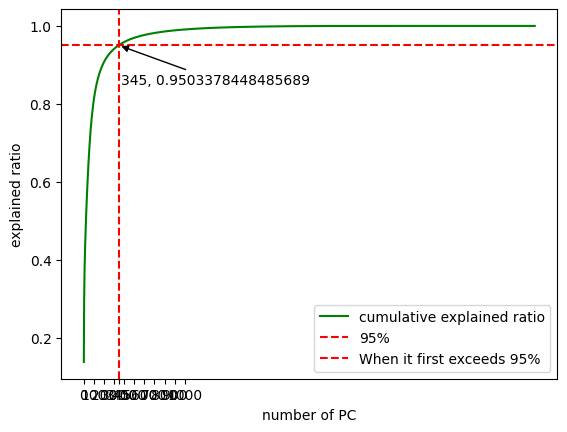

Least needed number of component that explains more than 95% of data is 345


In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

pca = PCA()

pca_X_train = pca.fit_transform(X_train)

cumul = np.cumsum(pca.explained_variance_ratio_)
plt.plot(cumul, color = 'green', label = 'cumulative explained ratio')

plt.axhline(y = 0.95, linestyle = '--', color = 'red', label = '95%')
n_comp = np.argmax(cumul >= 0.95) + 1
plt.axvline(x = n_comp, linestyle = '--', color='red', label = 'When it first exceeds 95%')

x_val = []
for i in range(0,1024,100):
    x_val.append(i)
x_val.append(n_comp)
plt.xticks(x_val)

arrowprops = dict(color='black',arrowstyle="-|>")
plt.annotate(str(int(n_comp)) + ", " + str(cumul[n_comp]), xy = (n_comp, cumul[n_comp]), xytext = (n_comp + 20, cumul[n_comp]-0.1), arrowprops=arrowprops)
plt.legend()

plt.xlabel('number of PC')
plt.ylabel('explained ratio')

plt.show()

print(f'Least needed number of component that explains more than 95% of data is {n_comp}')


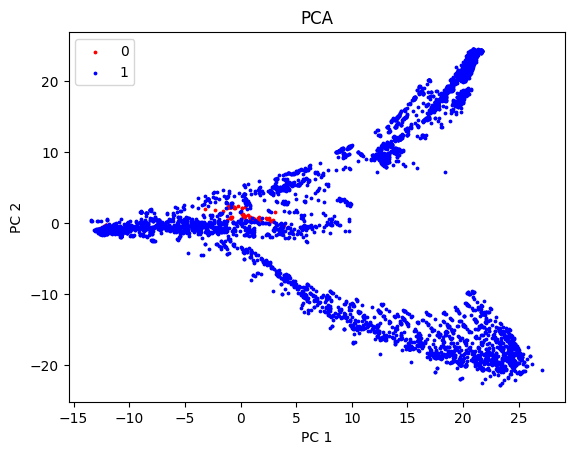

In [48]:
plt.scatter(pca_X_train[y_train==0, 0], pca_X_train[y_train==0, 1], color = 'red', label='0', s=3)
plt.scatter(pca_X_train[y_train==1, 0], pca_X_train[y_train==1, 1], color = 'blue', label='1', s=3)

plt.title('PCA')
plt.legend(loc='upper left')

plt.xlabel('PC 1')
plt.ylabel('PC 2')

plt.show()

In [49]:
pca = PCA(n_components = n_comp)
pca_X_train = pca.fit_transform(X_train)
pca_X_test = pca.transform(X_test)

In [50]:
svc_pca = SVC(kernel='rbf', C=10, gamma=0.01)
svc_pca.fit(pca_X_train, y_train)

predict = svc_pca.predict(pca_X_test)
score = accuracy_score(predict, y_test)

print('The accuracy of this model(PCA + SVC) is : {:.3f} %'.format(100 * score))

The accuracy of this model(PCA + SVC) is : 68.317 %


In [51]:
from sklearn.metrics import f1_score

score = f1_score(predict, y_test, average='macro')
print('The accuracy of this model is : {:.3f} %'.format(100 * score))

The accuracy of this model is : 75.159 %


In [55]:
LR_pca = LogisticRegression(solver='liblinear', C=100)
LR_pca.fit(pca_X_train, y_train)

predict = LR_pca.predict(pca_X_test)
score = f1_score(predict, y_test, average='macro')

print('The accuracy of this model(PCA + LR) is : {:.3f} %'.format(100 * score))

The accuracy of this model(PCA + LR) is : 74.701 %


In [54]:
DT_pca = DecisionTreeClassifier()
DT_pca.fit(pca_X_train, y_train)

predict = DT_pca.predict(pca_X_test)
score = f1_score(predict, y_test, average='macro')

print('The accuracy of this model(PCA + DT) is : {:.3f} %'.format(100 * score))

The accuracy of this model(PCA + DT) is : 69.042 %


In [52]:
RF_pca = RandomForestClassifier(random_state=42)
RF_pca.fit(pca_X_train, y_train)

predict = RF_pca.predict(pca_X_test)
score = f1_score(predict, y_test, average='macro')

print('The accuracy of this model(PCA + RF) is : {:.3f} %'.format(100 * score))

The accuracy of this model(PCA + RF) is : 75.358 %


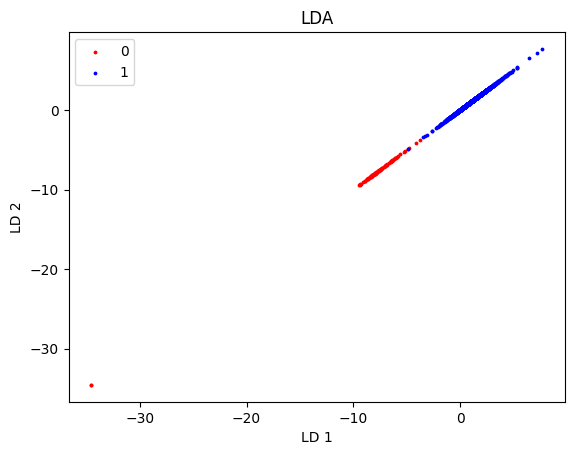

In [56]:
lda_ = LDA(n_components = 9 - 1)
lda_X_train = lda_.fit_transform(X_train, y_train)


plt.scatter(lda_X_train[y_train==0, 0], lda_X_train[y_train==0, 0], color = 'red', label='0', s=3)
plt.scatter(lda_X_train[y_train==1, 0], lda_X_train[y_train==1, 0], color = 'blue', label='1', s=3)

plt.title('LDA')
plt.legend(loc = 'upper left')

plt.xlabel('LD 1')
plt.ylabel('LD 2')

plt.show()

In [57]:
lda = LDA(n_components = 9 - 1)
lda_ = lda.fit(X_train, y_train)
lda_X_train = lda_.transform(X_train)
lda_X_test = lda_.transform(X_test)

In [58]:
# SVC with LDA-using demension reduced data
svc_lda = SVC(kernel='rbf', C=10, gamma=0.01)
svc_lda.fit(lda_X_train, y_train)

predict = svc_lda.predict(lda_X_test) 
score = accuracy_score(predict, y_test)

print('The accuracy of this model(LDA + SVC) is : {:.3f} %'.format(100 * score))

The accuracy of this model(LDA + SVC) is : 68.032 %


In [59]:
LR_lda = LogisticRegression(solver='liblinear', C=100)
LR_lda.fit(lda_X_train, y_train)

predict = LR_lda.predict(lda_X_test)
score = accuracy_score(predict, y_test)

print('The accuracy of this model(LDA + LR) is : {:.3f} %'.format(100 * score))

The accuracy of this model(LDA + LR) is : 69.159 %


In [60]:
DT_lda = DecisionTreeClassifier()
DT_lda.fit(lda_X_train, y_train)

predict = DT_lda.predict(lda_X_test)
score = accuracy_score(predict, y_test)

print('The accuracy of this model(LDA + DT) is : {:.3f} %'.format(100 * score))

The accuracy of this model(LDA + DT) is : 64.146 %


In [61]:
RF_lda = RandomForestClassifier(random_state=42)
RF_lda.fit(lda_X_train, y_train)

predict = RF_lda.predict(lda_X_test)
score = accuracy_score(predict, y_test)

print('The accuracy of this model(LDA + RF) is : {:.3f} %'.format(100 * score))

The accuracy of this model(LDA + RF) is : 69.549 %
